In [1]:
%matplotlib inline
# Switch to ''%matplotlib ipympl' for interactive plots
import warnings
import imp
import pickle
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt

warnings.filterwarnings("ignore")
plt.style.use('ggplot')

## 1. Load wrapper and input datasets

In [2]:
# Initialise wrapper and test datasets
wrapper_fpath = (r"..\inca.py")
optimize_funs_fpath = (r'..\inca_calibration.py')

wr = imp.load_source('inca',wrapper_fpath)
cf = imp.load_source('inca_calibration', optimize_funs_fpath)

catchment = 'Morsa' # Choose from: 'Morsa','Tarland'

wr.initialize('simplyp.dll')
dataset = wr.DataSet.setup_from_parameter_and_input_files('../../Applications/SimplyP/%s/%sParameters.dat' % (catchment, catchment),
                                                          '../../Applications/SimplyP/%s/%sInputs.dat' % (catchment, catchment))

## 2. Results from manual calibration

Show the output from Leah's manual calibration for comparison.

### 2.1. User options

In [3]:
# List of simulated and observed variables to investigate
comparisons = [('Reach flow (daily mean, cumecs)', ['Kure'], 'Observed Q', []),
               ('Reach suspended sediment concentration', ['Kure'], 'Observed SS at Kure', []),
               ('Reach TP concentration', ['Kure'], 'Observed TP at Kure', []),
               ('Reach TDP concentration', ['Kure'], 'Observed TDP at Kure', []),
               ('Reach PP concentration', ['Kure'], 'Observed PP at Kure', []),            
              ]

### 2.2. Plot results from manual calibration

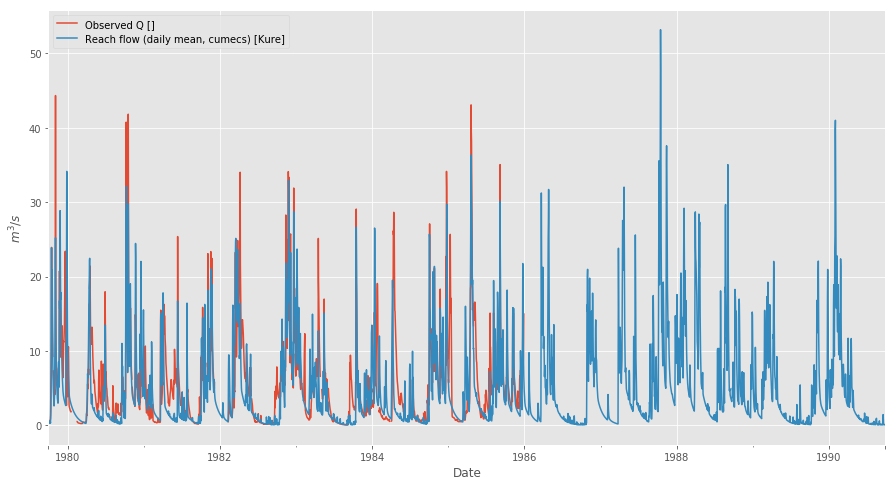

In [4]:
# Plot for Q
dataset.run_model()
objective = (0, comparisons, 0)
fig, ax = cf.plot_objective(dataset, objective, "simplyp_plots\\morsa_manual_calib_q.png", return_fig=True)


Goodness of fit for Reach flow (daily mean, cumecs) [Kure] vs Observed Q []:
Mean error (bias): -0.592782
Mean absolute error: 2.631394
Mean square error: 17.772676
Nash-Sutcliffe coefficient: 0.502809
Number of observations: 2069


Goodness of fit for Reach suspended sediment concentration [Kure] vs Observed SS at Kure []:
Mean error (bias): -39.854581
Mean absolute error: 52.931038
Mean square error: 30277.012835
Nash-Sutcliffe coefficient: 0.057763
Number of observations: 404


Goodness of fit for Reach TP concentration [Kure] vs Observed TP at Kure []:
Mean error (bias): -0.032819
Mean absolute error: 0.069039
Mean square error: 0.022183
Nash-Sutcliffe coefficient: 0.146248
Number of observations: 415


Goodness of fit for Reach TDP concentration [Kure] vs Observed TDP at Kure []:
Mean error (bias): 0.009568
Mean absolute error: 0.014214
Mean square error: 0.000413
Nash-Sutcliffe coefficient: -1.130266
Number of observations: 173


Goodness of fit for Reach PP concentration [Kure]

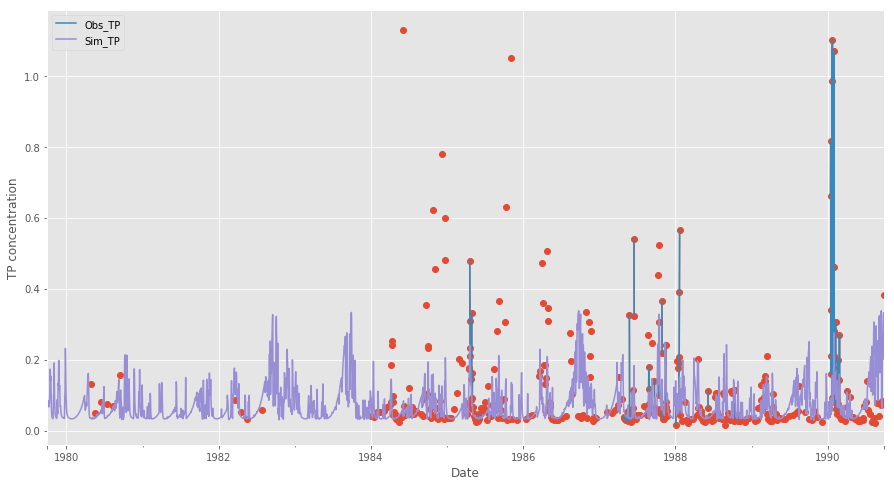

In [5]:
# Plot for TP
sim = dataset.get_result_series('Reach TP concentration', ['Kure'])
obs = dataset.get_input_series('Observed TP at Kure', [], alignwithresults=True)
start_date = dt.datetime.strptime(dataset.get_parameter_time('Start date', []),'%Y-%m-%d')
timesteps = dataset.get_parameter_uint('Timesteps', [])

# Use data to make a pandas dataframe
date_idx = np.array(pd.date_range(start_date, periods=timesteps))
df = pd.DataFrame({'Date':date_idx, 'Obs_TP': obs, 'Sim_TP': sim})
df.set_index('Date', inplace=True)

# Plot
fig, ax = plt.subplots()
df.Obs_TP.plot(marker='o', ax=ax)
df.plot(figsize=(15,8), ax=ax)
ax.set_ylabel('TP concentration')
plt.savefig("simplyp_plots\\morsa_manual_calib_tp.png", dpi=200)
cf.print_goodness_of_fit(dataset, objective)

## 3. Optimisation

### 3.1. User options

In [6]:
# CSV with parameters to vary, short names and param ranges
# NOTE: The Ms must be included as the last rows in this file, named 'M_XXX'
# DO NOT name any other parameters as 'M_'
fpath = r'SimplyP_calParams_ranges_morsa_v3.csv'

# Choose objective func (either cf.sum_of_squares or cf.log_likelyhood)
obj_func = cf.sum_of_squares

# Skip this many first timesteps in the objective evaluation
skiptimesteps = 30   

### 3.2. Setup optimiser

In [7]:
# Check valid objective
if obj_func == cf.sum_of_squares:
    minimize = True
elif obj_func == cf.log_likelyhood:
    minimize = False
else:
    raise ValueError("'obj_func' must be either cf.sum_of_squares or cf.log_likelyhood.") 
    
# Read csv
param_df = pd.read_csv(fpath)

# Build lists of calibrating pars & indexes
calibration = []
for idx, row in param_df.iterrows():
    name = row['Param_long']
    index = row['Indexes']        
        
    if pd.isnull(index):
        cal = (name, [])
    else:
        cal = (name, [index])
        
    calibration.append(cal)   

# Get initial guesses and prior ranges for parameters
param_min = param_df['Min'].values
initial_guess = param_df['Initial'].values
param_max = param_df['Max'].values
labels_short = param_df['ShortName'].values
labels_long = param_df['Param_long'].values

n_ms = len([i for i in labels_long if i[:2]=='M_'])

# Check values in CSV against 'master' ranges defined in MorsaParameters.dat and adjust if necessary
cf.constrain_min_max(dataset, calibration, param_min, param_max, n_ms)  # NOTE: Constrain to the min and max values recommended
                                                                        # by the model in case we made our bounds too wide.

objective = (obj_func, comparisons, skiptimesteps)

### 3.3. Run optimiser

In [8]:
%%time

param_est = cf.run_optimization(dataset, param_min, param_max, initial_guess, calibration, 
                                objective, minimize=minimize, n_ms=n_ms)

# Print results
for idx, cal in enumerate(calibration):
    name, indexes = cal
    print('Estimated %-60s %-20s %5.2f (range [%5.2f, %5.2f])' %  (name, ', '.join(indexes),
                                                                   param_est[idx],
                                                                   param_min[idx], param_max[idx]))

Optimization terminated successfully.
         Current function value: 4267.061352
         Iterations: 4609
         Function evaluations: 6484
Estimated Degree-day factor for snowmelt                                                     1.86 (range [ 0.50,  4.00])
Estimated Proportion of precipitation that contributes to quick flow                         0.02 (range [ 0.00,  0.20])
Estimated PET multiplication factor                                                          0.61 (range [ 0.50,  1.00])
Estimated Baseflow index                                                                     0.60 (range [ 0.10,  0.60])
Estimated Groundwater time constant                                                         35.06 (range [15.00, 100.00])
Estimated Soil water time constant                                     Semi-natural          1.39 (range [ 1.00, 15.00])
Estimated Reach sediment input scaling factor                                               27696.85 (range [500.00, 50000.00])


### 3.4. Plot results

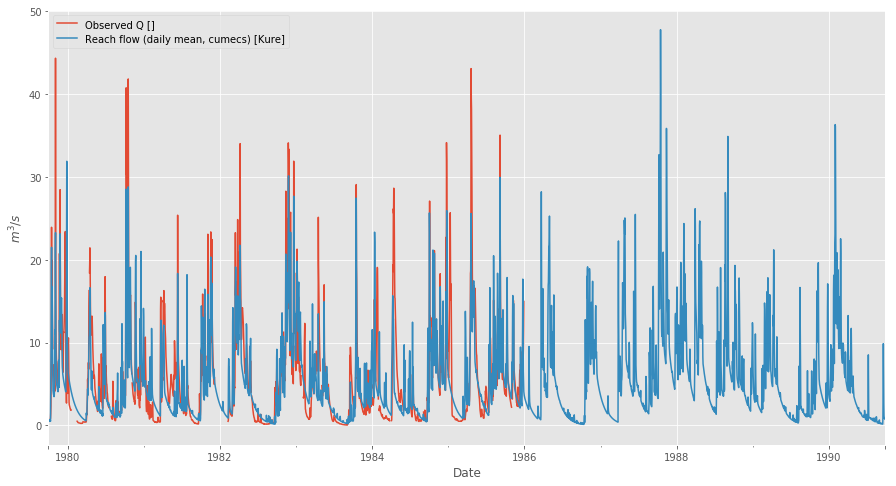

In [9]:
# Set 'best' parameter set
cf.set_values(dataset, param_est, calibration, n_ms)
# dataset.write_parameters_to_file('optimal_parameters.dat')

dataset.run_model()
fig, ax = cf.plot_objective(dataset, objective, "simplyp_plots\\morsa_optimizer_map_q.png", return_fig=True)


Goodness of fit for Reach flow (daily mean, cumecs) [Kure] vs Observed Q []:
Mean error (bias): -0.198748
Mean absolute error: 2.386667
Mean square error: 14.340245
Nash-Sutcliffe coefficient: 0.598832
Number of observations: 2069


Goodness of fit for Reach suspended sediment concentration [Kure] vs Observed SS at Kure []:
Mean error (bias): 8.076474
Mean absolute error: 68.668187
Mean square error: 26847.344386
Nash-Sutcliffe coefficient: 0.164496
Number of observations: 404


Goodness of fit for Reach TP concentration [Kure] vs Observed TP at Kure []:
Mean error (bias): -0.005678
Mean absolute error: 0.072362
Mean square error: 0.019117
Nash-Sutcliffe coefficient: 0.264256
Number of observations: 415


Goodness of fit for Reach TDP concentration [Kure] vs Observed TDP at Kure []:
Mean error (bias): 0.000804
Mean absolute error: 0.008966
Mean square error: 0.000191
Nash-Sutcliffe coefficient: 0.013265
Number of observations: 173


Goodness of fit for Reach PP concentration [Kure] vs

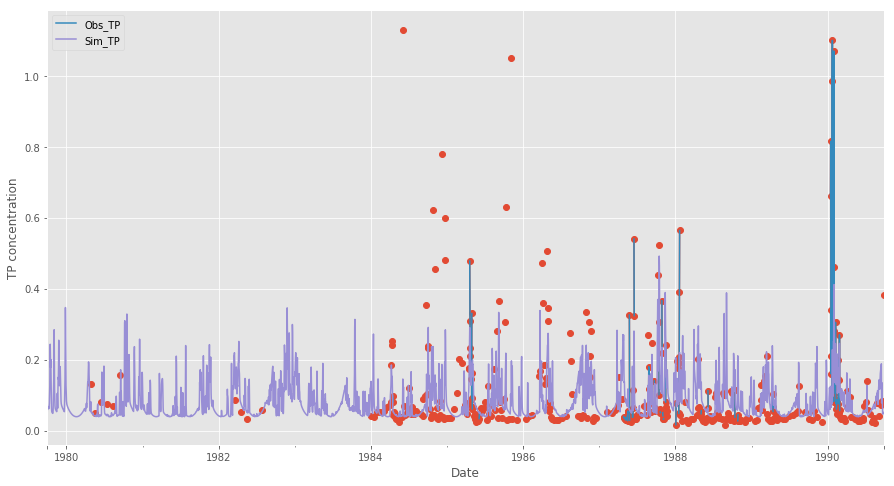

In [10]:
# Read data from the dataset
sim = dataset.get_result_series('Reach TP concentration', ['Kure'])
obs = dataset.get_input_series('Observed TP at Kure', [], alignwithresults=True)
start_date = dt.datetime.strptime(dataset.get_parameter_time('Start date', []),'%Y-%m-%d')
timesteps = dataset.get_parameter_uint('Timesteps', [])

# Use data to make a pandas dataframe
date_idx = np.array(pd.date_range(start_date, periods=timesteps))
df = pd.DataFrame({'Date':date_idx, 'Obs_TP': obs, 'Sim_TP': sim})
df.set_index('Date', inplace=True)

# Plot
fig, ax = plt.subplots()
df.Obs_TP.plot(marker='o', ax=ax)
df.plot(figsize=(15,8), ax=ax)
ax.set_ylabel('TP concentration')
plt.savefig("simplyp_plots\\morsa_optimizer_map_tp.png", dpi=200)
cf.print_goodness_of_fit(dataset, objective)

## 4. MCMC

In [11]:
# emcee setup
n_walk = 100
n_steps = 1000
n_burn = 500

# Starting params. Either 'manual' or 'optimised'
start_params = 'optimised'

In [12]:
# Save settings for passing to MCMC
settings_dict = {'comparisons':comparisons,
                 'skiptimesteps':skiptimesteps,
                 'calibration':calibration,
                 'n_ms':n_ms,
                 'param_min':param_min,
                 'param_max':param_max,        
                 'labels_short':labels_short,
                 'labels_long':labels_long,
                 'n_walk':n_walk,
                 'n_steps':n_steps,
                 'n_burn':n_burn,
                }

if start_params == 'manual':
    settings_dict['initial_guess'] = initial_guess
elif start_params == 'optimised':
    settings_dict['initial_guess'] = param_est
else:
    raise ValueError("'start_params' must be either 'manual' or 'optimised'.")

with open('pickled\\mcmc_settings.pkl', 'wb') as handle:
    pickle.dump(settings_dict, handle)

Time elapsed running emcee: 56.05 minutes
EMCEE average acceptance rate: 0.33

Best sample (max log likelihood):

Goodness of fit for Reach flow (daily mean, cumecs) [Kure] vs Observed Q []:
Mean error (bias): -0.054237
Mean absolute error: 2.165821
Mean square error: 13.806781
Nash-Sutcliffe coefficient: 0.613755
Number of observations: 2069


Goodness of fit for Reach suspended sediment concentration [Kure] vs Observed SS at Kure []:
Mean error (bias): -0.858232
Mean absolute error: 71.119522
Mean square error: 28842.103059
Nash-Sutcliffe coefficient: 0.102418
Number of observations: 404


Goodness of fit for Reach TP concentration [Kure] vs Observed TP at Kure []:
Mean error (bias): 0.012243
Mean absolute error: 0.089097
Mean square error: 0.022196
Nash-Sutcliffe coefficient: 0.145755
Number of observations: 415


Goodness of fit for Reach TDP concentration [Kure] vs Observed TDP at Kure []:
Mean error (bias): -0.003031
Mean absolute error: 0.008779
Mean square error: 0.000180
Nash-

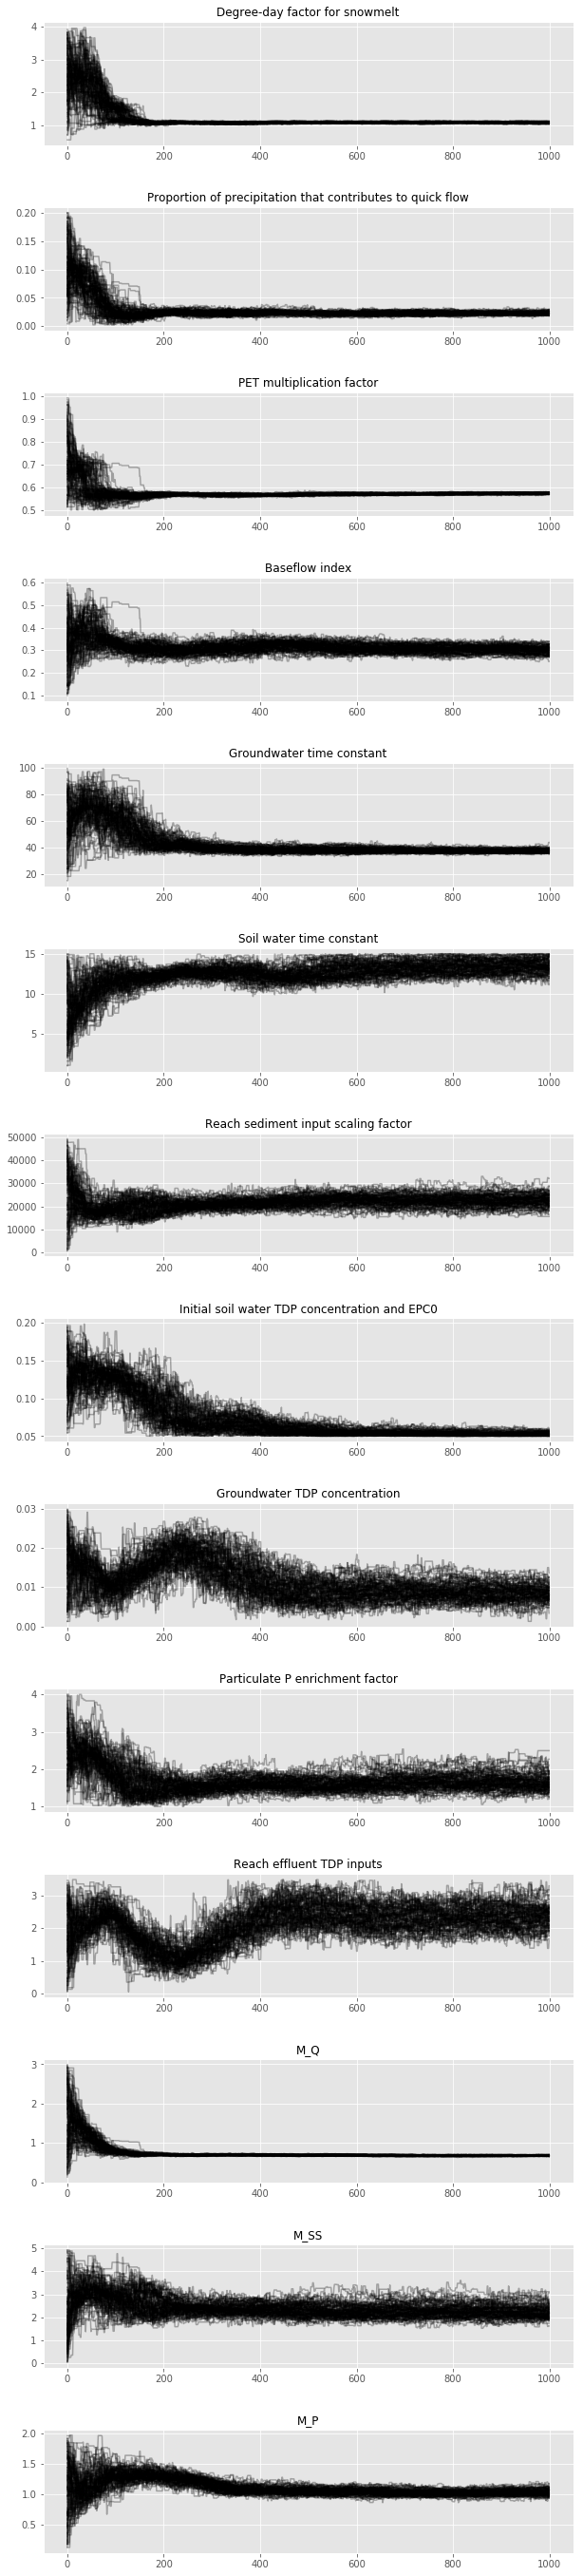

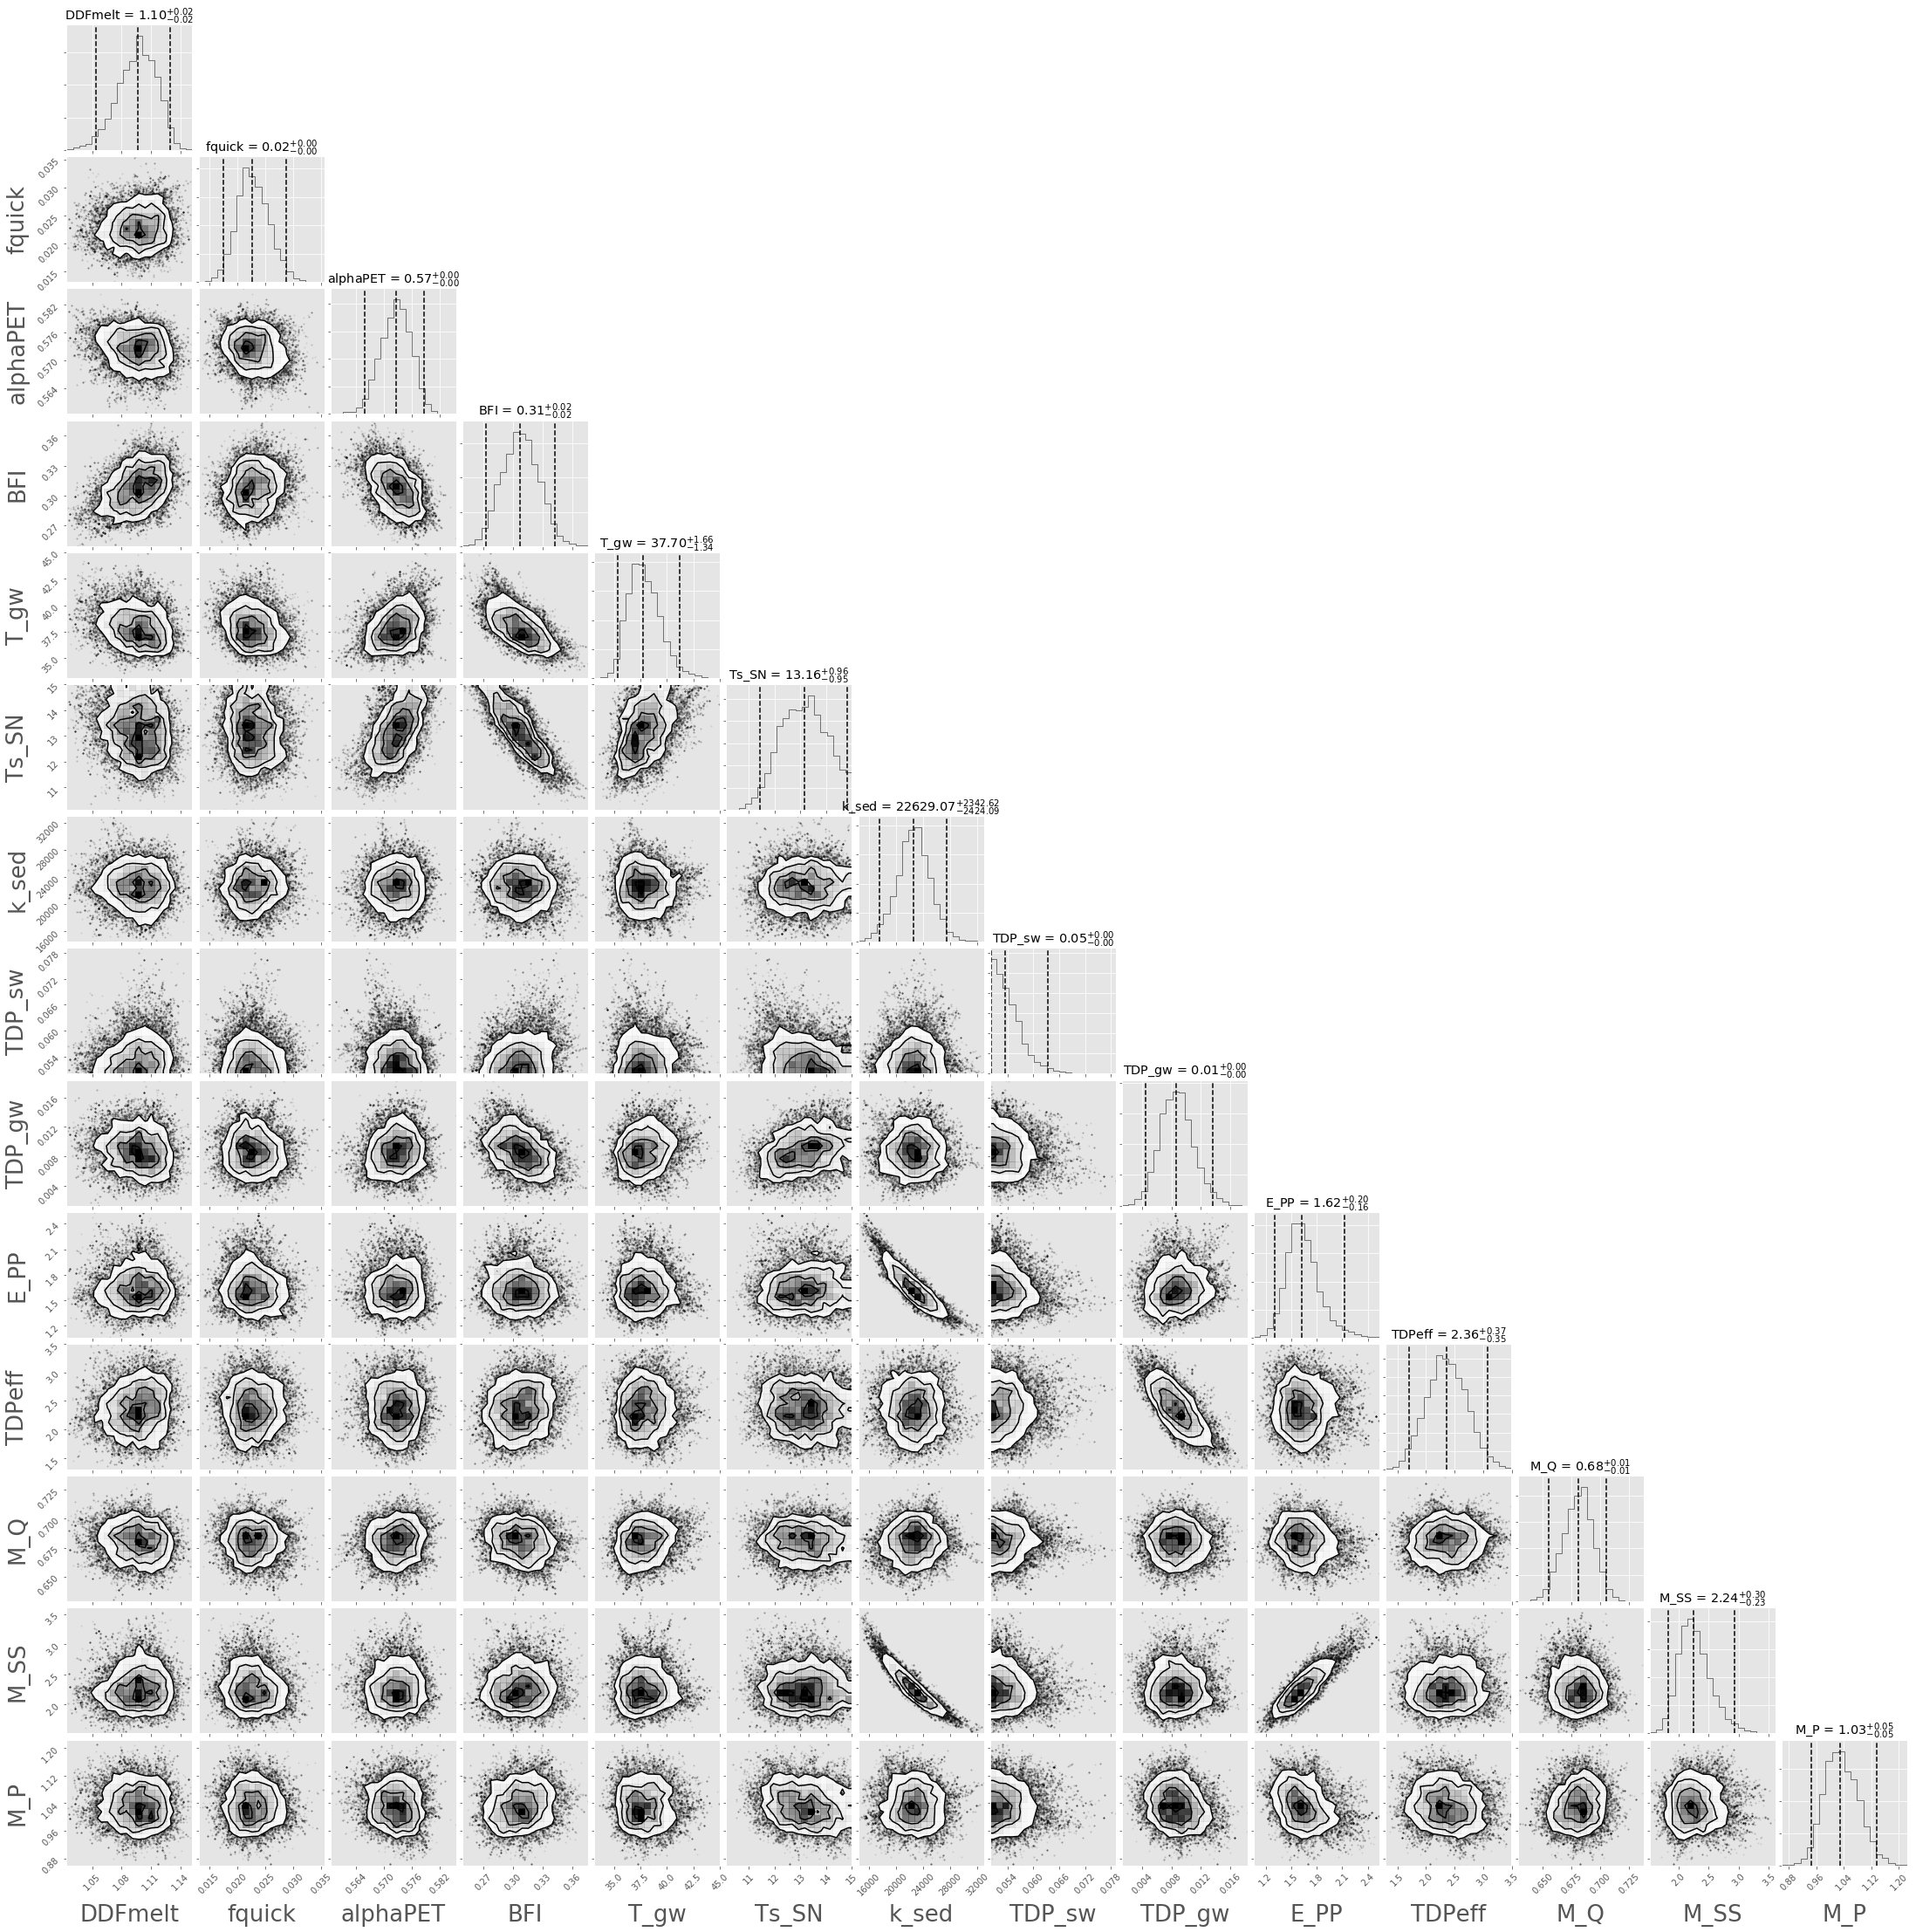

In [13]:
%run -i simplyp_emcee_Morsa.py